In [1]:
import numpy as np

from keras.datasets import imdb
from keras.layers import Dense
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import LSTM, Activation, Dropout
from keras.layers import GRU
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing import sequence

import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns

Using TensorFlow backend.


### Part 1 Processing Data: eliminate non-stationarity

In [2]:
btcprice = pd.read_csv('btcprice.csv')
ltcprice=pd.read_csv("ltcprice.csv")
bondprice=pd.read_csv("bondindex.csv")#S&P bond index
n_transaction=pd.read_csv("n_transaction.csv")#number of transactions per day BTC
btcpricevol=pd.read_csv("pricevol.csv")#BTC price volatility
transaction_amount=pd.read_csv("transactionamount.csv")#Transaction amount per trade BTC
transaction_feevalue=pd.read_csv("transactionfeesvalue.csv")#Transaction fees received BTC
velocity=pd.read_csv("velocitydaily.csv")#Velocity of BTC
minerrevenue=pd.read_csv("minerrevenuevalue.csv")#miner revenue BTC
btcoutput=pd.read_csv("btcoutput.csv")# BTC output
reit=pd.read_csv("reit.csv")# Real estate Index
vix=pd.read_csv("VIX.csv")#volatility index
ltcvolume=pd.read_csv("ltcvolume.csv")#LTC trading volume
sp500=pd.read_csv("SP500.csv")#S&P 500 stock index
oil=pd.read_csv("oilprice.csv")#oil price index
goldprice=pd.read_csv("goldprice.csv")#gold price index

In [3]:
btcprice["Date"]=pd.to_datetime(btcprice["Date"])
ltcprice["Date"]=pd.to_datetime(ltcprice["Date"])
bondprice["Date"]=pd.to_datetime(bondprice["Date"])
n_transaction["Date"]=pd.to_datetime(n_transaction["Date"])
btcpricevol["Date"]=pd.to_datetime(btcpricevol["Date"])
transaction_amount["Date"]=pd.to_datetime(transaction_amount["Date"])
transaction_feevalue["Date"]=pd.to_datetime(transaction_feevalue["Date"])
velocity["Date"]=pd.to_datetime(velocity["Date"])
minerrevenue["Date"]=pd.to_datetime(minerrevenue["Date"])
btcoutput["Date"]=pd.to_datetime(btcoutput["Date"])
reit["Date"]=pd.to_datetime(reit["Date"])
vix["Date"]=pd.to_datetime(vix["Date"])
ltcvolume["Date"]=pd.to_datetime(ltcvolume["Date"])
sp500["Date"]=pd.to_datetime(sp500["Date"])
oil["Date"]=pd.to_datetime(oil["Date"])
goldprice["Date"]=pd.to_datetime(goldprice["Date"])

##### Interpolation of missing data

In [4]:
merged=pd.merge(btcprice, ltcprice, on='Date', how='left')
merged.columns=['Date', 'btcprice', 'ltcprice']
merged=merged.fillna(0)
merged=pd.merge(merged, bondprice, on='Date', how='left')
bondindex=merged["bondindex"].interpolate()
bondindex[0:3]=347.72
merged["bondindex"]=bondindex
merged=pd.merge(merged, n_transaction, on='Date', how='left')
merged=pd.merge(merged, btcpricevol, on='Date', how='left')
merged=merged.fillna(0)
merged=pd.merge(merged, transaction_amount, on="Date",how="left")
merged=pd.merge(merged, transaction_feevalue, on="Date",how="left")
merged=pd.merge(merged, velocity, on="Date",how="left")
merged=pd.merge(merged, minerrevenue, on="Date",how="left")
merged=pd.merge(merged, btcoutput, on="Date",how="left")
merged=pd.merge(merged, reit, on="Date",how="left")
reitcolumn=merged["REIT"].interpolate()
reitcolumn[0:3]=114.98
merged["REIT"]=reitcolumn
merged=pd.merge(merged, vix, on="Date",how="left")
VIXcolumn=merged["VIX"].interpolate()
VIXcolumn[0:3]=20.04
merged["VIX"]=VIXcolumn
merged=pd.merge(merged, ltcvolume, on="Date",how="left")
merged=merged.fillna(0)
merged=pd.merge(merged, sp500, on="Date",how="left")
sp500p=merged["SP500price"].interpolate()
sp500p[0:3]=1132.98999
merged["SP500price"]=sp500p
sp500v=merged["SP500volume"].interpolate()
sp500v[0:3]=3991400000
merged["SP500volume"]=sp500v

merged=pd.merge(merged, oil, on="Date",how="left")
oilcolumn=merged["oil"].interpolate()
oilcolumn[0:3]=81.51
merged["oil"]=oilcolumn

merged=pd.merge(merged, goldprice, on="Date",how="left")
goldcolumn=merged["goldprice"].interpolate()
goldcolumn[0:3]=1117.7
merged["goldprice"]=goldcolumn

goldcolumn=merged["goldvolume"].interpolate()
goldcolumn[0:3]=0.18
merged["goldvolume"]=goldcolumn

##### Eliminate Non-stationarity

In [5]:
res=adfuller(merged["btcprice"])
print(res[1])
btcprice=merged["btcprice"]
btcpricereturn=np.diff(btcprice)
res=adfuller(btcpricereturn)
print(res[1])
merged["btcprice return"]=np.append(0,btcpricereturn)

0.5983344997611726
3.7284878983749615e-20


In [6]:
np.std(btcpricereturn)

182.91055228954195

In [7]:
ltcprice=merged["ltcprice"]
ltcpricereturn=np.diff(ltcprice)
res=adfuller(ltcprice)
print(res[1])
res=adfuller(ltcpricereturn)
print(res[1])
merged["ltcprice return"]=np.append(0,ltcpricereturn)

0.12948703331350558
1.0423338689839313e-24


In [8]:
res=adfuller(merged["bondindex"])
print(res[1])
bondindex=merged["bondindex"]
bondindexreturn=np.diff(bondindex)
res=adfuller(bondindexreturn)
print(res[1])
merged["bond return"]=np.append(0,bondindexreturn)

0.839601225899153
0.0


In [9]:
res=adfuller(merged["Daily Transactions"])
print(res[1])
transactions=merged["Daily Transactions"]
diff_transactions=np.diff(transactions)
res=adfuller(diff_transactions)
print(res[1])
merged["transactions change"]=np.append(0,diff_transactions)

0.8572130750433979
3.388537773811732e-24


In [10]:
res=adfuller(merged["btcpricevola"])
print(res[1])

res=adfuller(merged["Transaction Amount"])
print(res[1])

res=adfuller(merged["Fees Value"])
print(res[1])

res=adfuller(merged["Velocity"])
print(res[1])

res=adfuller(merged["Miner Revenue Value"])
print(res[1])
diff_minerrev=np.diff(merged["Miner Revenue Value"])
res=adfuller(diff_minerrev)
print(res[1])
merged["minerrevenue change"]=np.append(0,diff_minerrev)

res=adfuller(merged["Output Value"])
print(res[1])
diff_output=np.diff(merged["Output Value"])
res=adfuller(diff_output)
print(res[1])
merged["output change"]=np.append(0,diff_output)

res=adfuller(merged["REIT"])
print(res[1])
diff_reit=np.diff(merged["REIT"])
res=adfuller(diff_reit)
print(res[1])
merged["REIT return"]=np.append(0,diff_reit)

res=adfuller(merged["VIX"])
print(res[1])

res=adfuller(merged["ltcvolume"])
print(res[1])

res=adfuller(merged["SP500price"])
print(res[1])
diff_SPprice=np.diff(merged["SP500price"])
res=adfuller(diff_SPprice)
print(res[1])
merged["SPprice return"]=np.append(0,diff_SPprice)

res=adfuller(merged["SP500volume"])
print(res[1])

res=adfuller(merged["oil"])
print(res[1])
diff_oil=np.diff(merged["oil"])
res=adfuller(diff_oil)
print(res[1])
merged["oil return"]=np.append(0,diff_oil)

res=adfuller(merged["goldprice"])
print(res[1])
diff_goldp=np.diff(merged["goldprice"])
res=adfuller(diff_goldp)
print(res[1])
merged["gold return"]=np.append(0,diff_goldp)

res=adfuller(merged["goldvolume"])
print(res[1])

0.00030133014590080765
5.271887999403351e-11
5.434933901155005e-09
5.567147338390935e-11
0.12187296367108574
3.3192905081796003e-19
0.856692861496287
1.1433427300465514e-19
0.30786165795632137
0.0
7.0895202903251e-05
1.2390724071748057e-06
0.9397012439975668
2.0742783085226875e-30
3.7073542252455677e-06
0.6339175350576203
0.0
0.20617741238878767
7.15166249506842e-26
0.8532193105055546


Table of stationary data

In [11]:
data=merged[["Date","btcprice return","ltcprice return","bond return","transactions change","btcpricevola",
     'Transaction Amount', 'Fees Value', 'Velocity','minerrevenue change','output change','REIT return',
     'VIX', 'ltcvolume','SPprice return','SP500volume','oil return','gold return','goldvolume']]
np.sum(data.isna())

Date                   0
btcprice return        0
ltcprice return        0
bond return            0
transactions change    0
btcpricevola           0
Transaction Amount     0
Fees Value             0
Velocity               0
minerrevenue change    0
output change          0
REIT return            0
VIX                    0
ltcvolume              0
SPprice return         0
SP500volume            0
oil return             0
gold return            0
goldvolume             0
dtype: int64

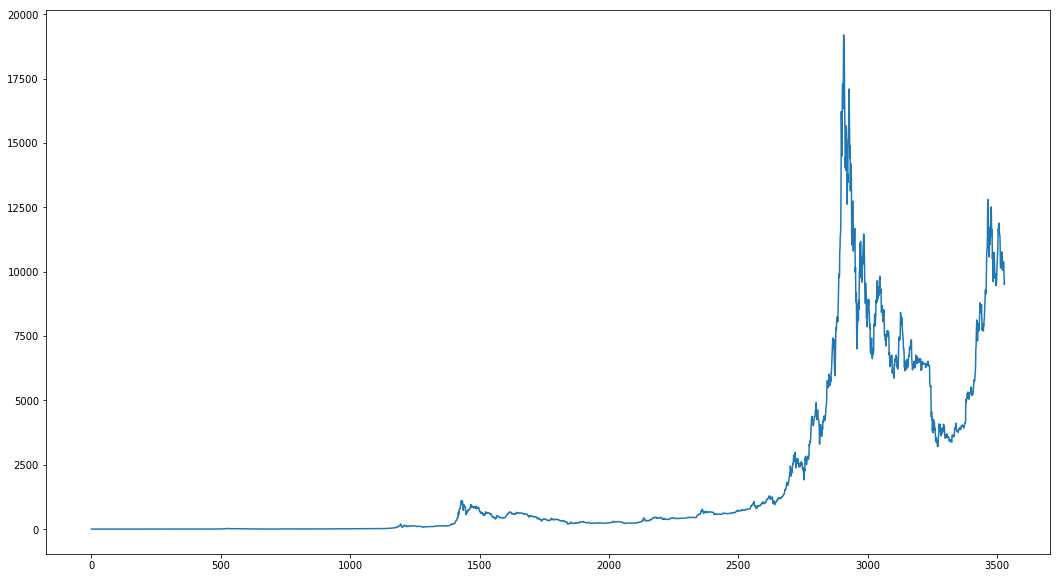

In [12]:
data.to_csv("prepared_data.csv",index=False)
plt.figure(figsize=(18,10))
plt.plot(merged["btcprice"])

In [13]:
datacol=data.columns[1:len(data.columns)]
fulldata=data.copy()

In [14]:
data_onlytrain=data[0:3103]

##### Normalization only using training data's mean and standard deviation, as future data is unobservable

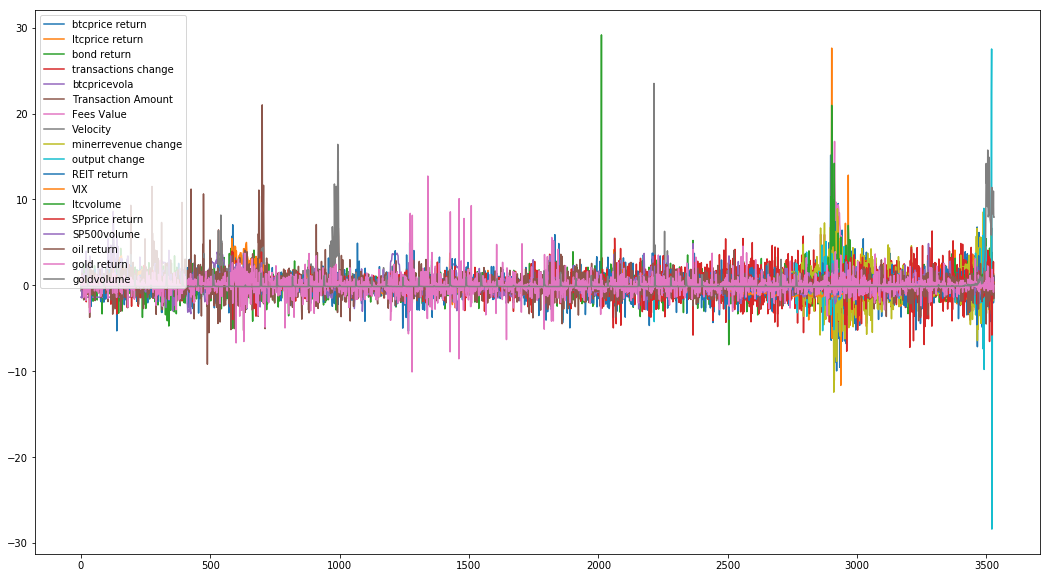

In [15]:
plt.figure(figsize=(18,10))
for i in datacol:
    fulldata[i]=(data[i]-np.mean(data_onlytrain[i]))/np.std(data_onlytrain[i])
    plotvalue=(data[i]-np.mean(data[i]))/np.std(data[i])
    plt.plot(plotvalue,label=i)
    plt.legend(loc='upper left')

##### Correlation Matrix

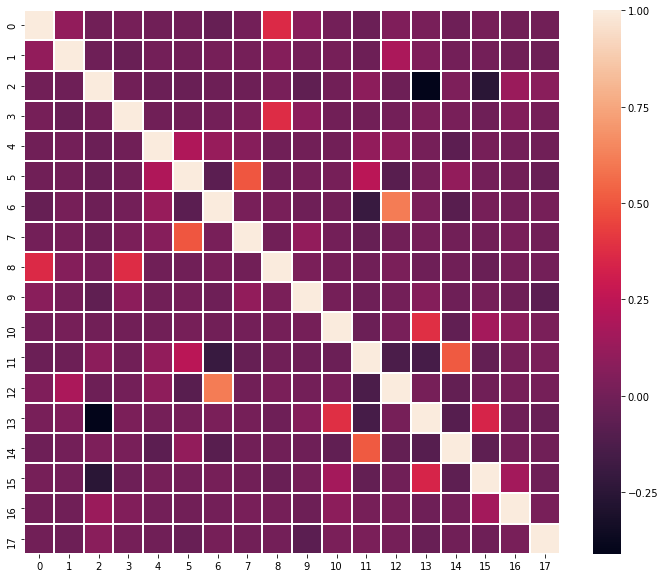

In [16]:
datamat=np.array(fulldata[datacol]).T
datacorr=np.corrcoef(datamat)
plt.figure(figsize=(12,10))
ax = sns.heatmap(datacorr, linewidth=1)
plt.show()

##### Correlation

Bitcoin price return is positively significant correlated with Litecoin price return, miner revenue change and output change. Average transaction amount per trade is positively correlated with BTC price volatility and velocity. Mining fees value is highly correlated with the LTC trading volume, which does not seem to offer a sensible connection. REIT return is highly correlated with S&P 500 return, VIX is highly correlated with S&P 500 trading volume. Oil price return is highly correlated with S&P500 price return.

### Part 2 Split Train, Validate and Test

In [23]:
traindata=fulldata[0:3103]
validatdata=fulldata[3103:3287]
testdata=fulldata[3287:3468]
holdoutdata=fulldata[3468:]

In [24]:
trainstd=np.std(merged["btcprice return"][1:3103])
trainmean=np.mean(merged["btcprice return"][1:3103])

In [25]:
xtrain=np.zeros([3069,28,18])
ytrain=np.zeros([3069,7])
for i in range(3069):
    xtrain[i,:,:]=traindata.iloc[i:(i+28),1:]
    ytrain[i,:]=traindata.iloc[(i+28):(i+35),1]
print(xtrain.shape)
print(ytrain.shape)

(3069, 28, 18)
(3069, 7)


In [26]:
xvalid=np.zeros([150,28,18])
yvalid=np.zeros([150,7])
for i in range(150):
    xvalid[i,:,:]=validatdata.iloc[i:(i+28),1:]
    yvalid[i,:]=validatdata.iloc[(i+28):(i+35),1]
print(xvalid.shape)
print(yvalid.shape)

(150, 28, 18)
(150, 7)


In [27]:
xtest=np.zeros([147,28,18])
ytest=np.zeros([147,7])
for i in range(147):
    xtest[i,:,:]=testdata.iloc[i:(i+28),1:]
    ytest[i,:]=testdata.iloc[(i+28):(i+35),1]
print(xtest.shape)
print(ytest.shape)

(147, 28, 18)
(147, 7)


In [133]:
xholdout=np.zeros([28,28,18])
yholdout=np.zeros([28,7])
for i in range(28):
    xholdout[i,:,:]=holdoutdata.iloc[i:(i+28),1:]
    yholdout[i,:]=holdoutdata.iloc[(i+28):(i+35),1]
print(xholdout.shape)
print(yholdout.shape)

(28, 28, 18)
(28, 7)


### Part 3 Model Building

##### 1.Average and Most Recent

In [28]:
btcprice_valid=np.array(merged["btcprice"][3103:3287])
forecast_naiv1=np.zeros(150)
forecast_naiv2=np.zeros(150)
for i in range(150):
    forecast_naiv1[i]=np.average(btcprice_valid[i:(i+28)])#average of 28 days
    forecast_naiv2[i]=btcprice_valid[28+i]#last day of those 28 days


In [29]:
valid_mat=np.zeros([150,7])
for i in range(150):
    valid_mat[i,:]=btcprice_valid[(i+28):(i+35)]
forecast_naiv1=np.reshape(forecast_naiv1,[150,1])
mae_naivavg=np.mean(np.abs(forecast_naiv1-valid_mat))
print("for validation set, the MAE of taking the average is ", mae_naivavg)

for validation set, the MAE of taking the average is  547.1514646258503


In [30]:
forecast_naiv2=np.reshape(forecast_naiv2,[150,1])
mae_naivrecent=np.mean(np.abs(forecast_naiv2-valid_mat))
print("for validation set, the MAE of taking the average is ", mae_naivrecent)

for validation set, the MAE of taking the average is  219.35503809523811


Obviously, the second method performs better.

##### 2. Neural Network: 2 dense layers

In [31]:
model2 = Sequential()
model2.add(Flatten(input_shape=(28,18)))
model2.add(Dense(63,activation="relu"))
model2.add(Dense(7,activation="relu"))
model2.compile(loss='mean_absolute_error', optimizer='adam')
model2.fit(xtrain, ytrain, epochs=300, batch_size=100, verbose=2, validation_data=[xvalid,yvalid])

W0925 14:19:07.360551 20424 deprecation_wrapper.py:119] From C:\Users\kendt\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:63: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0925 14:19:07.391762 20424 deprecation_wrapper.py:119] From C:\Users\kendt\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:492: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0925 14:19:07.423004 20424 deprecation.py:506] From C:\Users\kendt\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1259: calling reduce_prod_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
W0925 14:19:07.438653 20424 deprecation_wrapper.py:119] From C:\Users\kendt\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3630: The name tf.random_uniform is deprecated.

Train on 3069 samples, validate on 150 samples
Epoch 1/300
 - 0s - loss: 0.4343 - val_loss: 0.7478
Epoch 2/300
 - 0s - loss: 0.2666 - val_loss: 0.7245
Epoch 3/300
 - 0s - loss: 0.2527 - val_loss: 0.7227
Epoch 4/300
 - 0s - loss: 0.2453 - val_loss: 0.7231
Epoch 5/300
 - 0s - loss: 0.2409 - val_loss: 0.7222
Epoch 6/300
 - 0s - loss: 0.2380 - val_loss: 0.7239
Epoch 7/300
 - 0s - loss: 0.2350 - val_loss: 0.7247
Epoch 8/300
 - 0s - loss: 0.2336 - val_loss: 0.7226
Epoch 9/300
 - 0s - loss: 0.2314 - val_loss: 0.7254
Epoch 10/300
 - 0s - loss: 0.2305 - val_loss: 0.7235
Epoch 11/300
 - 0s - loss: 0.2298 - val_loss: 0.7226
Epoch 12/300
 - 0s - loss: 0.2279 - val_loss: 0.7230
Epoch 13/300
 - 0s - loss: 0.2260 - val_loss: 0.7228
Epoch 14/300
 - 0s - loss: 0.2249 - val_loss: 0.7224
Epoch 15/300
 - 0s - loss: 0.2243 - val_loss: 0.7250
Epoch 16/300
 - 0s - loss: 0.2236 - val_loss: 0.7225
Epoch 17/300
 - 0s - loss: 0.2225 - val_loss: 0.7259
Epoch 18/300
 - 0s - loss: 0.2228 - val_loss: 0.7216
Epoch 19

Epoch 154/300
 - 0s - loss: 0.1971 - val_loss: 0.7285
Epoch 155/300
 - 0s - loss: 0.1971 - val_loss: 0.7291
Epoch 156/300
 - 0s - loss: 0.1966 - val_loss: 0.7321
Epoch 157/300
 - 0s - loss: 0.1964 - val_loss: 0.7292
Epoch 158/300
 - 0s - loss: 0.1965 - val_loss: 0.7275
Epoch 159/300
 - 0s - loss: 0.1966 - val_loss: 0.7286
Epoch 160/300
 - 0s - loss: 0.1964 - val_loss: 0.7293
Epoch 161/300
 - 0s - loss: 0.1963 - val_loss: 0.7278
Epoch 162/300
 - 0s - loss: 0.1966 - val_loss: 0.7283
Epoch 163/300
 - 0s - loss: 0.1957 - val_loss: 0.7296
Epoch 164/300
 - 0s - loss: 0.1962 - val_loss: 0.7317
Epoch 165/300
 - 0s - loss: 0.1957 - val_loss: 0.7320
Epoch 166/300
 - 0s - loss: 0.1958 - val_loss: 0.7322
Epoch 167/300
 - 0s - loss: 0.1959 - val_loss: 0.7317
Epoch 168/300
 - 0s - loss: 0.1951 - val_loss: 0.7302
Epoch 169/300
 - 0s - loss: 0.1957 - val_loss: 0.7293
Epoch 170/300
 - 0s - loss: 0.1951 - val_loss: 0.7341
Epoch 171/300
 - 0s - loss: 0.1955 - val_loss: 0.7299
Epoch 172/300
 - 0s - loss: 

Starting Price for 7-day prediction

In [139]:
#Construct true prices matrix for each set and period starting price for return calculation
starting_price=np.array(merged["btcprice"])[27:3096]
true_prices=np.zeros([3069,7])
for i in range(7):
    true_prices[:,i]=np.array(merged["btcprice"])[(28+i):(3097+i)]
    
validstarting_price=np.array(merged["btcprice"])[3130:3280]
validtrue_prices=np.zeros([150,7])
for i in range(7):
    validtrue_prices[:,i]=np.array(merged["btcprice"])[(3131+i):(3281+i)]
    
teststarting_price=np.array(merged["btcprice"])[3314:3461]
testtrue_prices=np.zeros([147,7])
for i in range(7):
    testtrue_prices[:,i]=np.array(merged["btcprice"])[(3315+i):(3462+i)]

holdoutstarting_price=np.array(merged["btcprice"])[3495:3523]
holdouttrue_prices=np.zeros([28,7])
for i in range(7):
    holdouttrue_prices[:,i]=np.array(merged["btcprice"])[(3496+i):(3524+i)]

In [33]:
#denormalize the returns and add back to the starting period prices
train_return=model2.predict(xtrain)*trainstd+trainmean
train_price=np.zeros([3069,7])
train_price[:,0]=starting_price+train_return[:,0]
for i in range(6):
    train_price[:,i+1]=train_price[:,i]+train_return[:,i+1]
train_mae=np.mean(np.abs(train_price-true_prices))
print("the loss for training set is ", train_mae)

valid_return=model2.predict(xvalid)*trainstd+trainmean
valid_price=np.zeros([150,7])
valid_price[:,0]=validstarting_price+valid_return[:,0]
for i in range(6):
    valid_price[:,i+1]=valid_price[:,i]+valid_return[:,i+1]
valid_mae=np.mean(np.abs(valid_price-validtrue_prices))
print("the loss for valid set is ", valid_mae)

the loss for training set is  89.28307269094377
the loss for valid set is  287.8308320824578


Training loss is much lower than validation loss.

##### 3. Recurrent: LSTM

In [34]:
model3 = Sequential()
# model.add(Flatten(input_shape=(28,18)))
# model.add(Dense(63,activation="relu"))
model3.add(LSTM(4, input_shape=(28, 18)))
model3.add(Dense(7,activation="relu"))
model3.compile(loss='mean_absolute_error', optimizer='adam')
model3.fit(xtrain, ytrain, epochs=70, batch_size=100, verbose=2, validation_data=[xvalid,yvalid])

W0925 14:21:32.981852 20424 deprecation.py:506] From C:\Users\kendt\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1242: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
W0925 14:21:33.309906 20424 deprecation.py:323] From C:\Users\kendt\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3069 samples, validate on 150 samples
Epoch 1/70
 - 1s - loss: 0.3091 - val_loss: 0.7168
Epoch 2/70
 - 0s - loss: 0.2853 - val_loss: 0.7132
Epoch 3/70
 - 0s - loss: 0.2739 - val_loss: 0.7114
Epoch 4/70
 - 0s - loss: 0.2683 - val_loss: 0.7106
Epoch 5/70
 - 0s - loss: 0.2656 - val_loss: 0.7101
Epoch 6/70
 - 0s - loss: 0.2643 - val_loss: 0.7100
Epoch 7/70
 - 0s - loss: 0.2635 - val_loss: 0.7100
Epoch 8/70
 - 0s - loss: 0.2631 - val_loss: 0.7100
Epoch 9/70
 - 0s - loss: 0.2628 - val_loss: 0.7100
Epoch 10/70
 - 0s - loss: 0.2627 - val_loss: 0.7100
Epoch 11/70
 - 0s - loss: 0.2625 - val_loss: 0.7100
Epoch 12/70
 - 0s - loss: 0.2624 - val_loss: 0.7100
Epoch 13/70
 - 0s - loss: 0.2624 - val_loss: 0.7100
Epoch 14/70
 - 0s - loss: 0.2623 - val_loss: 0.7100
Epoch 15/70
 - 1s - loss: 0.2622 - val_loss: 0.7100
Epoch 16/70
 - 1s - loss: 0.2622 - val_loss: 0.7101
Epoch 17/70
 - 1s - loss: 0.2621 - val_loss: 0.7101
Epoch 18/70
 - 1s - loss: 0.2620 - val_loss: 0.7101
Epoch 19/70
 - 1s - loss: 

In [35]:
train_return=model3.predict(xtrain)*trainstd+trainmean
train_price=np.zeros([3069,7])
train_price[:,0]=starting_price+train_return[:,0]
for i in range(6):
    train_price[:,i+1]=train_price[:,i]+train_return[:,i+1]
train_mae=np.mean(np.abs(train_price-true_prices))
print("the loss for training set is ", train_mae)

valid_return=model3.predict(xvalid)*trainstd+trainmean
valid_price=np.zeros([150,7])
valid_price[:,0]=validstarting_price+valid_return[:,0]
for i in range(6):
    valid_price[:,i+1]=valid_price[:,i]+valid_return[:,i+1]
valid_mae=np.mean(np.abs(valid_price-validtrue_prices))
print("the loss for valid set is ", valid_mae)

the loss for training set is  93.70108590743132
the loss for valid set is  281.606811018526


Training loss is slightly worse than previous method, but validation loss is better now. It might be due to the better method.

##### 4. Recurrent: GRU

In [52]:
model4 = Sequential()
model4.add(GRU(8, input_shape=(28, 18)))
model4.add(Dense(7,activation="relu"))
model4.compile(loss='mean_absolute_error', optimizer='adam')
model4.fit(xtrain, ytrain, epochs=70, batch_size=100, verbose=2, validation_data=[xvalid,yvalid])

Train on 3069 samples, validate on 150 samples
Epoch 1/70
 - 1s - loss: 0.3758 - val_loss: 0.7216
Epoch 2/70
 - 0s - loss: 0.3252 - val_loss: 0.7116
Epoch 3/70
 - 0s - loss: 0.2934 - val_loss: 0.7088
Epoch 4/70
 - 0s - loss: 0.2771 - val_loss: 0.7084
Epoch 5/70
 - 0s - loss: 0.2694 - val_loss: 0.7082
Epoch 6/70
 - 0s - loss: 0.2655 - val_loss: 0.7084
Epoch 7/70
 - 0s - loss: 0.2633 - val_loss: 0.7087
Epoch 8/70
 - 0s - loss: 0.2621 - val_loss: 0.7088
Epoch 9/70
 - 0s - loss: 0.2612 - val_loss: 0.7088
Epoch 10/70
 - 0s - loss: 0.2605 - val_loss: 0.7087
Epoch 11/70
 - 0s - loss: 0.2600 - val_loss: 0.7086
Epoch 12/70
 - 0s - loss: 0.2597 - val_loss: 0.7085
Epoch 13/70
 - 0s - loss: 0.2593 - val_loss: 0.7085
Epoch 14/70
 - 0s - loss: 0.2590 - val_loss: 0.7084
Epoch 15/70
 - 0s - loss: 0.2588 - val_loss: 0.7083
Epoch 16/70
 - 0s - loss: 0.2586 - val_loss: 0.7083
Epoch 17/70
 - 0s - loss: 0.2583 - val_loss: 0.7083
Epoch 18/70
 - 0s - loss: 0.2581 - val_loss: 0.7083
Epoch 19/70
 - 0s - loss: 

In [37]:
train_return=model4.predict(xtrain)*trainstd+trainmean
train_price=np.zeros([3069,7])
train_price[:,0]=starting_price+train_return[:,0]
for i in range(6):
    train_price[:,i+1]=train_price[:,i]+train_return[:,i+1]
train_mae=np.mean(np.abs(train_price-true_prices))
print("the loss for training set is ", train_mae)

valid_return=model4.predict(xvalid)*trainstd+trainmean
valid_price=np.zeros([150,7])
valid_price[:,0]=validstarting_price+valid_return[:,0]
for i in range(6):
    valid_price[:,i+1]=valid_price[:,i]+valid_return[:,i+1]
valid_mae=np.mean(np.abs(valid_price-validtrue_prices))
print("the loss for valid set is ", valid_mae)

the loss for training set is  91.22563811720092
the loss for valid set is  279.8274608436403


Both traing loss and validation loss are better than the previous method.

##### 5. Recurrent: GRU with recurrent dropout

In [38]:
model5 = Sequential()
model5.add(GRU(8, input_shape=(28, 18),recurrent_dropout=0.5))
model5.add(Dense(7,activation="relu"))
model5.compile(loss='mean_absolute_error', optimizer='adam')
model5.fit(xtrain, ytrain, epochs=70, batch_size=100, verbose=2, validation_data=[xvalid,yvalid])

W0925 14:23:35.152606 20424 deprecation.py:506] From C:\Users\kendt\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3013: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 3069 samples, validate on 150 samples
Epoch 1/70
 - 1s - loss: 0.3666 - val_loss: 0.7380
Epoch 2/70
 - 0s - loss: 0.3218 - val_loss: 0.7231
Epoch 3/70
 - 0s - loss: 0.2942 - val_loss: 0.7156
Epoch 4/70
 - 0s - loss: 0.2784 - val_loss: 0.7124
Epoch 5/70
 - 0s - loss: 0.2703 - val_loss: 0.7108
Epoch 6/70
 - 0s - loss: 0.2666 - val_loss: 0.7101
Epoch 7/70
 - 0s - loss: 0.2648 - val_loss: 0.7099
Epoch 8/70
 - 0s - loss: 0.2638 - val_loss: 0.7097
Epoch 9/70
 - 0s - loss: 0.2631 - val_loss: 0.7095
Epoch 10/70
 - 0s - loss: 0.2626 - val_loss: 0.7094
Epoch 11/70
 - 0s - loss: 0.2621 - val_loss: 0.7093
Epoch 12/70
 - 0s - loss: 0.2616 - val_loss: 0.7091
Epoch 13/70
 - 0s - loss: 0.2613 - val_loss: 0.7090
Epoch 14/70
 - 0s - loss: 0.2609 - val_loss: 0.7089
Epoch 15/70
 - 0s - loss: 0.2607 - val_loss: 0.7088
Epoch 16/70
 - 0s - loss: 0.2604 - val_loss: 0.7087
Epoch 17/70
 - 0s - loss: 0.2601 - val_loss: 0.7085
Epoch 18/70
 - 0s - loss: 0.2599 - val_loss: 0.7085
Epoch 19/70
 - 0s - loss: 

In [39]:
train_return=model5.predict(xtrain)*trainstd+trainmean
train_price=np.zeros([3069,7])
train_price[:,0]=starting_price+train_return[:,0]
for i in range(6):
    train_price[:,i+1]=train_price[:,i]+train_return[:,i+1]
train_mae=np.mean(np.abs(train_price-true_prices))
print("the loss for training set is ", train_mae)

valid_return=model5.predict(xvalid)*trainstd+trainmean
valid_price=np.zeros([150,7])
valid_price[:,0]=validstarting_price+valid_return[:,0]
for i in range(6):
    valid_price[:,i+1]=valid_price[:,i]+valid_return[:,i+1]
valid_mae=np.mean(np.abs(valid_price-validtrue_prices))
print("the loss for valid set is ", valid_mae)

the loss for training set is  91.83468126291936
the loss for valid set is  277.92565463523863


Validation loss are better than the previous method. Also validation loss does not increase in the latter epochs.

##### 6 Recurrent: GRU with recurrent dropout

In [153]:
model6 = Sequential()
model6.add(GRU(16, input_shape=(28, 18),recurrent_dropout=0.5,return_sequences=True))
model6.add(GRU(8, recurrent_dropout=0.5,dropout=0.5,return_sequences=False))
model6.add(Dense(32,activation="relu"))
model6.add(Dense(7,activation="relu"))
model6.compile(loss='mean_absolute_error', optimizer='adam')
model6.fit(xtrain, ytrain, epochs=70, batch_size=100, verbose=2, validation_data=[xvalid,yvalid])

Train on 3069 samples, validate on 150 samples
Epoch 1/70
 - 3s - loss: 0.2895 - val_loss: 0.7090
Epoch 2/70
 - 1s - loss: 0.2657 - val_loss: 0.7091
Epoch 3/70
 - 1s - loss: 0.2632 - val_loss: 0.7091
Epoch 4/70
 - 1s - loss: 0.2626 - val_loss: 0.7091
Epoch 5/70
 - 1s - loss: 0.2626 - val_loss: 0.7091
Epoch 6/70
 - 1s - loss: 0.2626 - val_loss: 0.7091
Epoch 7/70
 - 1s - loss: 0.2626 - val_loss: 0.7091
Epoch 8/70
 - 1s - loss: 0.2626 - val_loss: 0.7091
Epoch 9/70
 - 1s - loss: 0.2626 - val_loss: 0.7091
Epoch 10/70
 - 1s - loss: 0.2626 - val_loss: 0.7091
Epoch 11/70
 - 1s - loss: 0.2626 - val_loss: 0.7091
Epoch 12/70
 - 1s - loss: 0.2626 - val_loss: 0.7091
Epoch 13/70
 - 1s - loss: 0.2625 - val_loss: 0.7091
Epoch 14/70
 - 1s - loss: 0.2625 - val_loss: 0.7091
Epoch 15/70
 - 1s - loss: 0.2625 - val_loss: 0.7091
Epoch 16/70
 - 1s - loss: 0.2626 - val_loss: 0.7092
Epoch 17/70
 - 1s - loss: 0.2624 - val_loss: 0.7091
Epoch 18/70
 - 1s - loss: 0.2623 - val_loss: 0.7091
Epoch 19/70
 - 1s - loss: 

In [157]:
train_return=model6.predict(xtrain)*trainstd+trainmean
train_price=np.zeros([3069,7])
train_price[:,0]=starting_price+train_return[:,0]
for i in range(6):
    train_price[:,i+1]=train_price[:,i]+train_return[:,i+1]
train_mae=np.mean(np.abs(train_price-true_prices))
print("the loss for training set is ", train_mae)

valid_return=model6.predict(xvalid)*trainstd+trainmean
valid_price=np.zeros([150,7])
valid_price[:,0]=validstarting_price+valid_return[:,0]
for i in range(6):
    valid_price[:,i+1]=valid_price[:,i]+valid_return[:,i+1]
valid_mae=np.mean(np.abs(valid_price-validtrue_prices))
print("the loss for valid set is ", valid_mae)

the loss for training set is  87.92476893382194
the loss for valid set is  287.4759059250241


Validation loss is worse than the previous method.

##### 7.ARIMA

In [42]:
arimadata=np.array(merged["btcprice"][0:3103])
arimamodel = ARIMA(arimadata, order=(1,1,0))
model_fit = arimamodel.fit(disp=0)
print(model_fit.summary())

arima_realmat=np.zeros([3069,7])
arima_forecastmat=np.zeros([3069,7])
for i in range(3069):
    arima_realmat[i,:]=arimadata[(28+i):(35+i)]
    
arima_forecastmat=np.zeros([3069,9])
arima_forecastmat[:,0]=merged["btcprice"][27:3096]
arima_forecastmat[:,1]=np.diff(arimadata)[26:3095]
arima_forecastprice=np.zeros([3069,8])
arima_forecastprice[:,0]=merged["btcprice"][27:3096]
for i in range(7):
    arima_forecastmat[:,i+2]=model_fit.params[0]+model_fit.params[1]*arima_forecastmat[:,i+1]
    arima_forecastprice[:,i+1]=arima_forecastprice[:,i]+arima_forecastmat[:,i+2]
arimatrain_mae=np.mean(arima_realmat-arima_forecastmat[:,1:8])
print("for training set, the MAE of using ARIMA is ",arimatrain_mae)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3102
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -20365.807
Method:                       css-mle   S.D. of innovations            171.819
Date:                Wed, 25 Sep 2019   AIC                          40737.613
Time:                        14:26:02   BIC                          40755.732
Sample:                             1   HQIC                         40744.119
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0096      3.331      0.603      0.546      -4.518       8.537
ar.L1.D.y      0.0737      0.018      4.117      0.000       0.039       0.109
                                    Roots           

In [43]:
valid_arima=np.array(merged["btcprice"][3103:3287])
valid_arimamat=np.zeros([150,9])
valid_arimaret=np.diff(valid_arima)
valid_arimamat[:,1]=valid_arimaret[26:176]
valid_arimaprice=np.zeros([150,8])
valid_arimaprice[:,0]=valid_arima[27:177]
for i in range(7):
    valid_arimamat[:,i+2]=model_fit.params[0]+model_fit.params[1]*valid_arimamat[:,i+1]
    valid_arimaprice[:,i+1]=valid_arimaprice[:,i]+valid_arimamat[:,i+2]

valid_realmat=np.zeros([150,7])
for i in range(150):
    valid_realmat[i,:]=valid_arima[(28+i):(35+i)]
arimavalid_mae=np.mean(valid_arimaprice[:,1:8]-valid_realmat) 
print("for validation set, the MAE of using ARIMA is ",arimavalid_mae)    

for validation set, the MAE of using ARIMA is  119.22141312991161


ARIMA(1,1,0) has a bad training loss, but an impressive validation loss.

##### Ensemble model

As BTC prices is non-stationary and we use BTC price returns as our dependent variable and previous price returns as independent variables, we implicitly imbedded ARIMA in our deep learning model. However, MA term is neglected here. One could additionally regress realized returns on estimator of returns by deep learning model and ARIMA estimator.

### Part 4 Compare models

##### 2 benchmark models

In [44]:
btcprice_test=np.array(merged["btcprice"][3287:3468])
forecast_naiv1test=np.zeros(147)
forecast_naiv2test=np.array(merged["btcprice"][3314:3461])
for i in range(147):
    forecast_naiv1test[i]=np.average(btcprice_test[i:(i+28)])


In [45]:
#7-day true prices in the test set
test_mat=np.zeros([147,7])
for i in range(147):
    test_mat[i,:]=btcprice_test[(i+28):(i+35)]
forecast_naiv1test=np.reshape(forecast_naiv1test,[147,1])
mae_naivavg_test=np.mean(np.abs(forecast_naiv1test-test_mat))
print("for test set, the MAE of taking the average is ", mae_naivavg_test)

for test set, the MAE of taking the average is  721.080755240872


In [46]:
forecast_naiv2test=np.reshape(forecast_naiv2test,[147,1])
mae_naivrecent_test=np.mean(np.abs(forecast_naiv2test-test_mat))
print("for test set, the MAE of taking the most recent observation is ", mae_naivrecent_test)

for test set, the MAE of taking the most recent observation is  319.9327113702624


##### 2 dense layers

In [47]:
#denormalize returns and add to the starting period prices
test_return=model2.predict(xtest)*trainstd+trainmean
test_price=np.zeros([147,7])
test_price[:,0]=teststarting_price+test_return[:,0]
for i in range(6):
    test_price[:,i+1]=test_price[:,i]+test_return[:,i+1]
test_mae=np.mean(np.abs(test_price-testtrue_prices))
print("the loss for test set is ", test_mae)

the loss for test set is  297.959619257902


##### 3 LSTM

In [48]:
test_return=model3.predict(xtest)*trainstd+trainmean
test_price=np.zeros([147,7])
test_price[:,0]=teststarting_price+test_return[:,0]
for i in range(6):
    test_price[:,i+1]=test_price[:,i]+test_return[:,i+1]
test_mae=np.mean(np.abs(test_price-testtrue_prices))
print("the loss for test set is ", test_mae)

the loss for test set is  297.90655024931664


##### 4 GRU

In [53]:
test_return=model4.predict(xtest)*trainstd+trainmean
test_price=np.zeros([147,7])
test_price[:,0]=teststarting_price+test_return[:,0]
for i in range(6):
    test_price[:,i+1]=test_price[:,i]+test_return[:,i+1]
test_mae=np.mean(np.abs(test_price-testtrue_prices))
print("the loss for test set is ", test_mae)

the loss for test set is  308.8270014098087


##### 5 GRU with recurrent dropout

In [50]:
test_return=model5.predict(xtest)*trainstd+trainmean
test_price=np.zeros([147,7])
test_price[:,0]=teststarting_price+test_return[:,0]
for i in range(6):
    test_price[:,i+1]=test_price[:,i]+test_return[:,i+1]
test_mae=np.mean(np.abs(test_price-testtrue_prices))
print("the loss for test set is ", test_mae)

the loss for test set is  296.53833299371775


##### 6 Two layers of GRU

In [158]:
test_return=model6.predict(xtest)*trainstd+trainmean
test_price=np.zeros([147,7])
test_price[:,0]=teststarting_price+test_return[:,0]
for i in range(6):
    test_price[:,i+1]=test_price[:,i]+test_return[:,i+1]
test_mae=np.mean(np.abs(test_price-testtrue_prices))
print("the loss for test set is ", test_mae)

the loss for test set is  282.6592824453237


##### The last model (2 layers GRU with dropout) performs best in the test set due to its regularization. It outperforms the best naiv model.

##### Part 5

We assume 0.3% transaction costs, i.e. 0.6% transaction costs per round trade.

1. We trade whenever we expect the price to increase over 7 days. For instance, on day 0, our forecasts says that price will increase over 7 days. Our first day in test sample is 3288th day and first observation period ends on 3315th day. On day 3315, if we expect the price to increase over 3316-3322 period, we will long the BTC on 3315th day and short on 3322th day. If we expect on 3322th day that BTC will appreciate over the next 7 days, we will long again on 3322th day and short on 3329th day. The last observation day is 3455th day and the potential sale day would be 3462th day. These are overall 21 days to make a decision whether to buy in the test set.

2. Improved strategy: do not sell at the end of 7-day period, if accumulated forecasted return over the next 7 days is larger than 0.008, to spare transaction costs. Buy in only if the accumulated forecasted return over the next 7 days is larger than 0.008.

##### validation set

In [148]:
valid_return=model5.predict(xvalid)*trainstd+trainmean
return_mat=np.sum(valid_return, axis=1)/validstarting_price
return_vec=np.zeros(22)
for i in range(22):
    return_vec[i]=return_mat[7*i]
totalreturn=1
for i in range(22):
    if return_vec[i]>0:
        totalreturn *= 1+(validtrue_prices[7*i,6]-validtrue_prices[7*i,0])/validstarting_price[7*i]-0.008
print("in the validation set, the naive strategy's totalreturn is ", totalreturn-1)
totalreturn=1
for i in range(22):
    if return_vec[i]>0.008:
        totalreturn *= 1+(validtrue_prices[7*i,6]-validtrue_prices[7*i,0])/validstarting_price[7*i]
print("in the validation set, the improved strategy's totalreturn is ", totalreturn-0.024-1)

in the validation set, the naive strategy's totalreturn is  -0.5589964559886467
in the validation set, the improved strategy's totalreturn is  0.07325957438214536


In [126]:
np.where(return_vec>0.008)

(array([ 5,  7,  8, 20], dtype=int64),)

Due to the uncertainty of the model, one invests only when the predicted accumulated returns are over 0.008, which happens in both 7th and 8th period, requiring only 1 round-trade. $0.008*3$ is the total transaction cost this strategy needs, as it trades 3 times. The strategy in the naiv method fails miserably due to the uncertainty of the model. Model 5 and Model 6 deliver similar results.

##### test set

In [161]:
test_return=model5.predict(xtest)*trainstd+trainmean
return_mat=np.sum(test_return, axis=1)/teststarting_price
return_vec=np.zeros(21)
for i in range(21):
    return_vec[i]=return_mat[7*i]
totalreturn=1
for i in range(21):
    if return_vec[i]>0:
        totalreturn *= 1+(testtrue_prices[7*i,6]-testtrue_prices[7*i,0])/teststarting_price[7*i]-0.008
print("the naive strategy's totalreturn is ", totalreturn)

the naive strategy's totalreturn is  2.4454746302413266


In [162]:
totalreturn=1
for i in range(21):
    if return_vec[i]>0.008:
        totalreturn *= 1+(testtrue_prices[7*i,6]-testtrue_prices[7*i,0])/teststarting_price[7*i]

print("the improved strategy's totalreturn is ", totalreturn-0.016)

the improved strategy's totalreturn is  2.4979265493773597


In [129]:
np.where(return_vec>0.008)

(array([ 2,  3,  4,  5,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
       dtype=int64),)

The predicted accumulated returns over 7 days appear in 2 pieces, thus one only needs to trade twice.

##### Holdout set

In [149]:
holdout_return=model5.predict(xholdout)*trainstd+trainmean
return_mat=np.sum(holdout_return, axis=1)/holdoutstarting_price
return_vec=np.zeros(4)
for i in range(4):
    return_vec[i]=return_mat[7*i]
totalreturn=1
for i in range(4):
    if return_vec[i]>0.00:
        totalreturn *= 1+(holdouttrue_prices[7*i,6]-holdouttrue_prices[7*i,0])/holdoutstarting_price[7*i]-0.008
print("the naive strategy's totalreturn is ", totalreturn-1)

the naive strategy's totalreturn is  0.01750049884801963


In [156]:
holdout_return=model5.predict(xholdout)*trainstd+trainmean
return_mat=np.sum(holdout_return, axis=1)/holdoutstarting_price
return_vec=np.zeros(4)
for i in range(4):
    return_vec[i]=return_mat[7*i]
totalreturn=1
for i in range(4):
    if return_vec[i]>0.008:
        totalreturn *= 1+(holdouttrue_prices[7*i,6]-holdouttrue_prices[7*i,0])/holdoutstarting_price[7*i]
print("the improved strategy's totalreturn is ", totalreturn-0.008-1)

the improved strategy's totalreturn is  0.04243958565468664


In [155]:
np.where(return_vec>0.008)

(array([0, 1, 2, 3], dtype=int64),)

The predicted accumulated returns over 7 days appear in one piece. One only trade once. However, the model was not able to predict negative returns in 2 of those 4 periods.